# [Noise Cancellation with Python and Fourier Transform](https://towardsdatascience.com/noise-cancellation-with-python-and-fourier-transform-97303314aa71)

### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import pywt
#from scipy import signal
from scipy.optimize import curve_fit

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import scipy
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 
          'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 
          'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue','xkcd:scarlet']

### Function Definitions

In [4]:
def filter_signal(threshold, signal, period):
    """This is a wrapper function that filters a signal and returns the
    filtered signal in the time domain.

    Args:
        threshold (int): This is the threshold at which to filter the
                         signal.
        signal (numpy.ndarray): This is the time domain representation
                                of the signal.
        period (numpy.ndarray): This is the period of the fast fourier
                                transform signal.

    Returns:
        numpy.array: This is the time domain representation of the
                     filtered transform.
    """
    f_s = fft_filter(threshold)
    return np.real(np.fft.ifft(f_s))

def fft_filter(percent, signal, period):
    """This function transforms a time domain signal into the frequency
       domain before defining a threshold that is the input percentage
       of the maximum of twice the magnitude of half the length of the
       signal divided by the length of the period. The fast fourier
       transform of the signal is then copied, and transformed by taking
       twice the magnitude of the signal divided by the period. The
       original fft of the signal is then indexed by the fft of the
       absolute value of twice the magnitude of the fft divided by the
       period and subsequently thresholded to zero where frequencies are
       less than or equal to the threshold.

    Args:
        percent (float): The percent to which the signal will be
                         thresholded.
        signal (numpy.ndarray): The time domain version of the signal.
        period (numpy.ndarray): The period of the fast fourier transform
                                of the signal.

    Returns:
        numpy.ndarray: This is the filtered array filtered by the
                       thresholded value.
    """

    fft_signal = np.fft.fft(signal)
    fft_abs = np.abs(fft_signal)
    threshold=percent*(2*fft_abs[0:len(signal)//2.])/len(period).max()
    fft_tof = fft_signal.copy()
    fft_tof_abs = np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(period)
    fft_tof[fft_tof_abs<=threshold]=0
    return fft_tof

def fft_filter_amp(threshold, signal, period):
    """This function filters the absolute value of twice the magnitude
       of the fast fourier transform divided by the length of the
       period.

    Args:
        threshold (int): This is the desired threshold at which to
                         filter the signal.
        signal (numpy.ndarray): This is the time domain representation 
                                of a signal.
        period (numpy.ndarray): This is the period of the fast fourier
                                transform of the signal.

    Returns:
        numpy.ndarray: This returns the filtered fast fourier transform.
    """
    fft = np.fft.fft(signal)
    fft_tof=fft.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(period)
    fft_tof_abs[fft_tof_abs<=threshold]=0
    tmp = fft_tof_abs[0:int(len(fft_tof_abs))//2]
    return tmp


In [5]:
data = pd.read_csv('./Kaggle_Datasets/Microsoft_Stock.csv')
data.head()
# type(data)
data.Date = pd.to_datetime(data.Date)
data.head()

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


## Creating a Continuous Time Series of Closing Values with No Missing Data

Text(0, 0.5, 'Close')

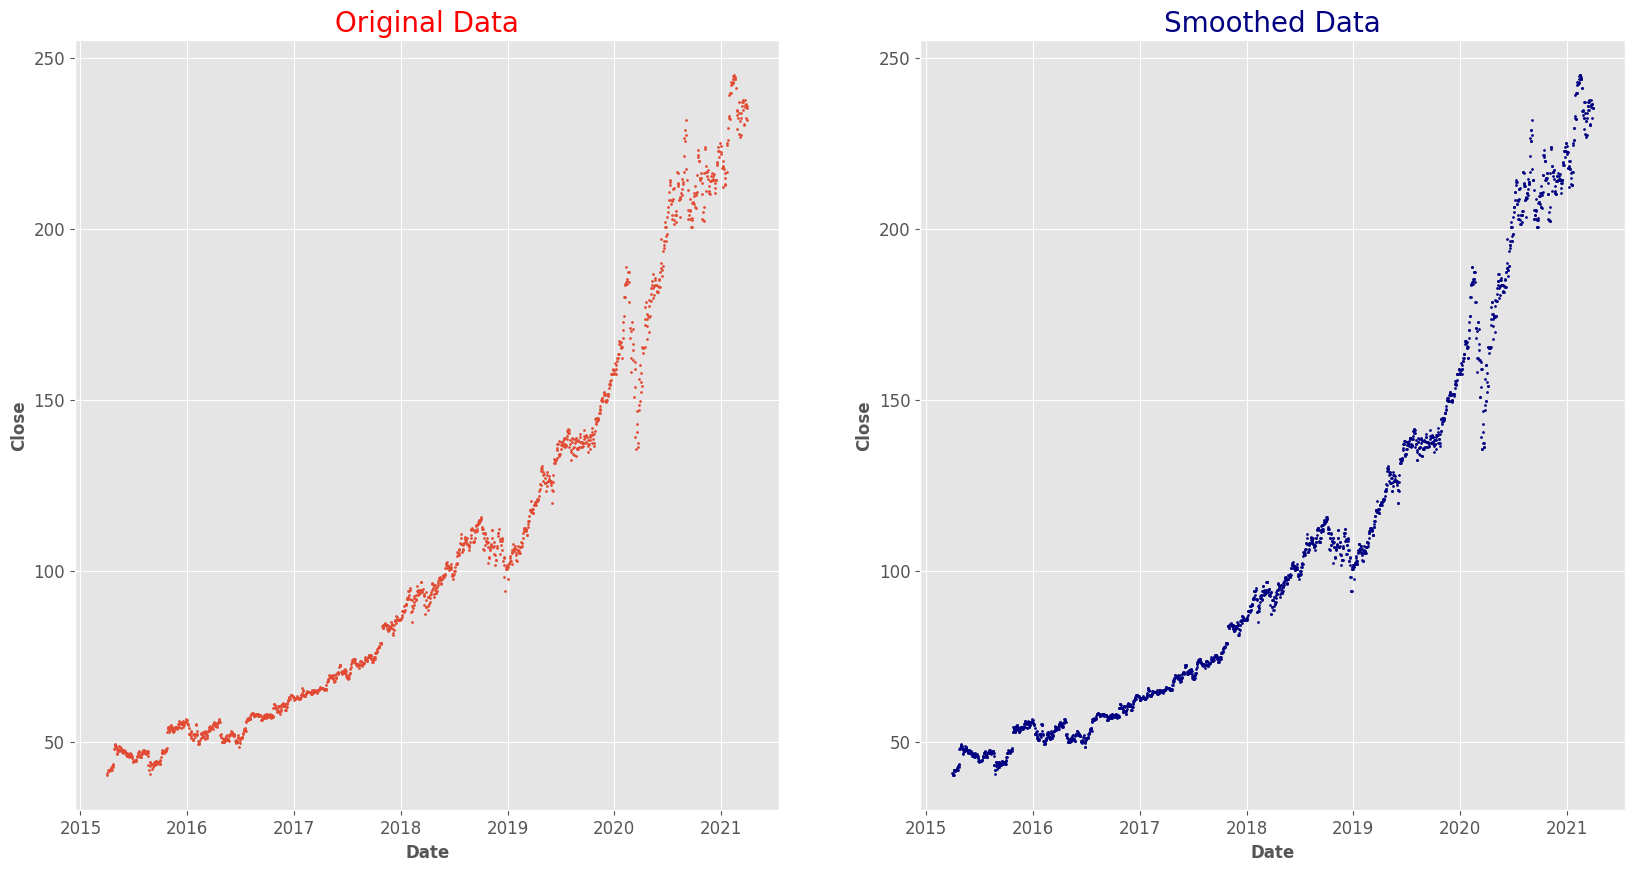

In [6]:
# This algorithm creates a pandas Series inclusive of the range of dates
# between the first and last dates from the original date Series.
# It then creates a list of the difference for each date in the new 
# range of dates with respect to each date in the original date Series,
# calculates the minimum difference of in each list, and uses the 
# minimum difference to "look up" the associated Closing Price on that
# date before appending that price to a new list of prices. 
# This ultimately creates a list for every date within the original 
# range of dates that has no missing values because the missing values 
# are continued from the most recent date in the original date Series.

start_date = data.Date.loc[0]
end_date = data.Date.loc[len(data)-1]
start_year = start_date.year
start_month =  start_date.month
start_day = start_date.day
end_year = end_date.year
end_month =  end_date.month
end_day = end_date.day
number_of_days = abs((end_date-start_date).days)
start_date = datetime.date(start_date.year, start_date.month, start_date.day)
date_list = []
for day in range(number_of_days):
    a_date = (start_date + datetime.timedelta(days = day)).isoformat()
    date_list.append(a_date)
date_list = pd.to_datetime(date_list)
new_data = pd.DataFrame({'Date':date_list})
x = new_data.Date
old_x = data.Date
y = []
for i in range(len(x)):
    x_i = x.loc[i]
    diff_list = []
    for j in range(len(data)):
        diff_list.append(abs((x_i-old_x.loc[j]).days))
    diff_list = np.array(diff_list)
    y.append(data.Close[diff_list.argmin()])

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title('Original Data', color='red', fontsize=20)
plt.scatter(data.Date, data.Close, s=2)
plt.xlabel('Date')
plt.ylabel('Close')
plt.subplot(1, 2, 2)
plt.title('Smoothed Data', color='navy', fontsize=20)

plt.scatter(x, y, s=2, color='navy')
plt.xlabel('Date')
plt.ylabel('Close')


## Removing Trend by Fitting a Polynomial Regression to the Data to Create Stationary Data

Text(0, 0.5, 'Price')

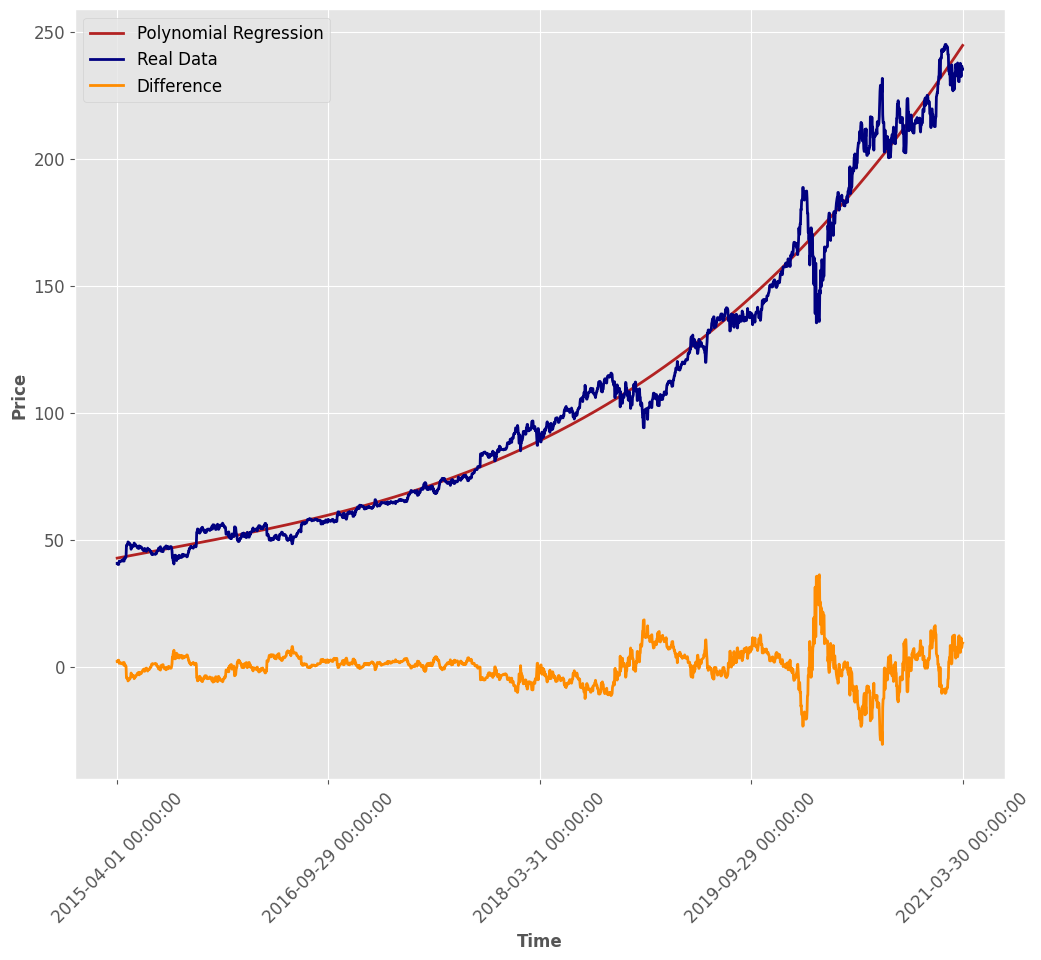

In [7]:
idx = np.linspace(0,len(x)-1,5).astype(int)
X = np.array(new_data.index).reshape(-1,1)
pf = PolynomialFeatures(3)
X = pf.fit_transform(X)
# y = 1 * x_0 + 2 * x_1 + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)
plt.plot(x,reg.predict(X),label='Polynomial Regression',color='firebrick')
plt.plot(x,y,label='Real Data',color='navy')
plt.plot(x,reg.predict(X)-y,label='Difference',color='darkorange')
plt.legend()
plt.xticks(x[idx],x[idx],rotation=45)
plt.xlabel('Time')
plt.ylabel('Price')

## Denoising Algorithm

Text(0, 0.5, 'Fourier Amplitude')

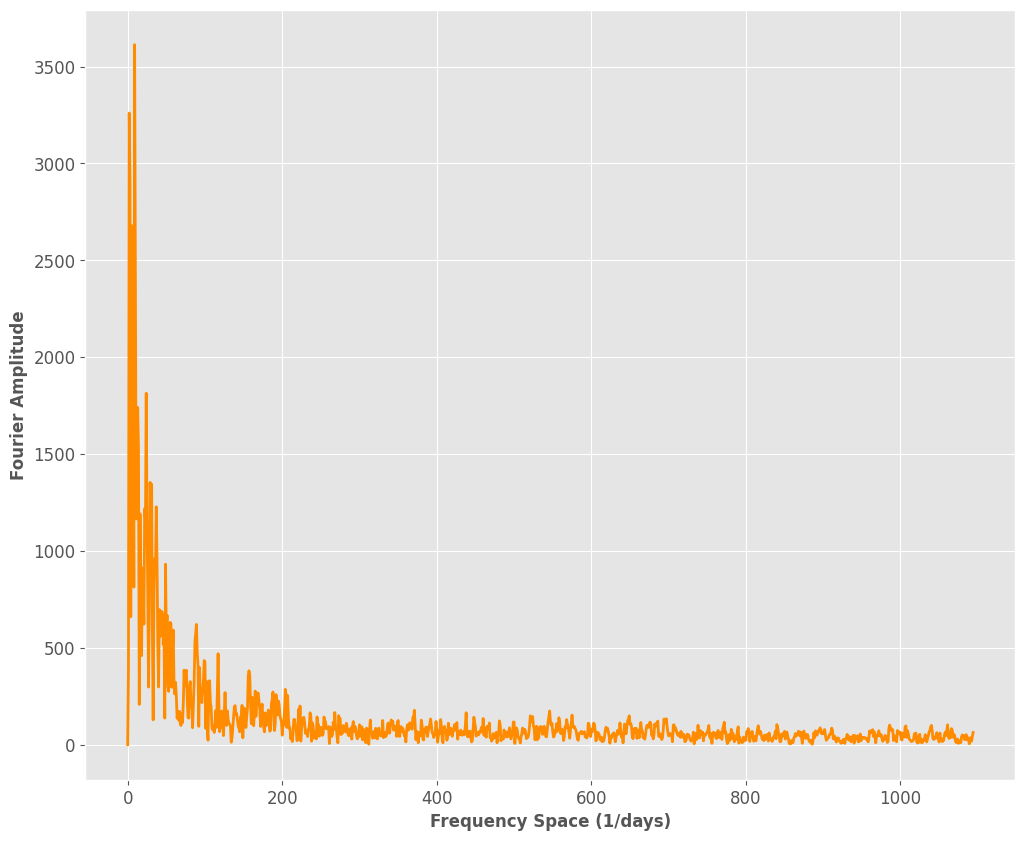

In [8]:
signal = reg.predict(X) - y
signal = signal - signal.mean()
fft_signal = np.abs(np.fft.fft(signal))
f_nat = 1
frequencies = np.linspace(10**-12, f_nat/2, len(fft_signal)//2, endpoint=True)
period = 1/frequencies

plt.plot(fft_signal[0:int(len(signal)/2.)], color='darkorange')
plt.xlabel('Frequency Space (1/days)')
plt.ylabel('Fourier Amplitude')
